In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Return Forecasting: Read Historical Daily Yen Futures Data

In this notebook, we will perform time series analysis and modeling on the historical Dollar-Yen exchange rate futures data. Our goal is to determine whether there is any predictable behavior.

First we load the historical data from the attached `yen.csv` file, which contains the futures contract on the Yen-dollar exchange rates. The data is a continuous chain of the futures contracts that are 1 month to expiration.

In [2]:
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


Let us trim the dataset to begin on January 1st, 1990

In [3]:
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

**Start by plotting the "Settle" price.**

In this section, we will plot time series data. The y-axis represents the **Yen Futrues Settle Prices** and the x-axis represents the time, to help us visualize any obvious patterns over the years.

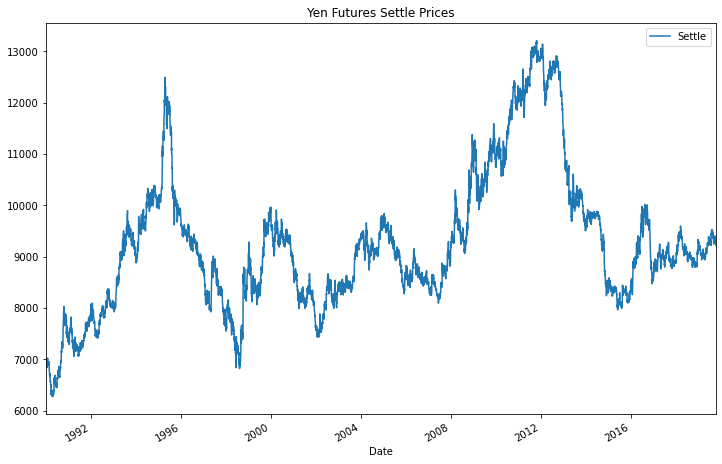

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures['Settle'].plot(
    title='Yen Futures Settle Prices', 
    legend='Settle', 
    figsize=(12, 8))
plt.margins(x=0)

**Do you see any patterns, long-term and/or short?**

From the above graph, we observe an upward trend in the long-term. We also see a variation in the short-term, that is in every two-four years there is significant reversal in the price.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
settle_price_df = pd.DataFrame(yen_futures['Settle'])
settle_price_df['noise'] = settle_noise
settle_price_df['trend'] = settle_trend
settle_price_df.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


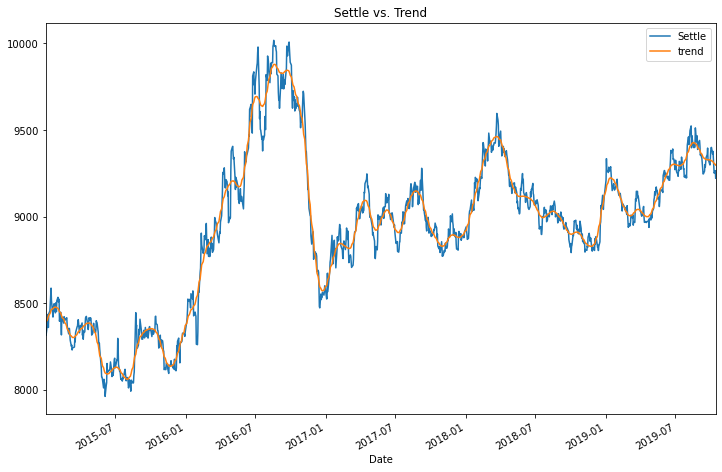

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
settle_price_2015_to_present = settle_price_df['Settle'].loc['2015-01-01':]
trend_2015_to_present = settle_price_df['trend'].loc['2015-01-01':]

settle_price_vs_trend_2015_to_present = pd.concat(
    [settle_price_2015_to_present, trend_2015_to_present],
    axis="columns", 
    join="inner"
    )
settle_price_vs_trend_2015_to_present.plot(
    title='Settle vs. Trend', 
    legend=['Settle', 'trend'],
    figsize=(12, 8)
)
plt.margins(x=0)

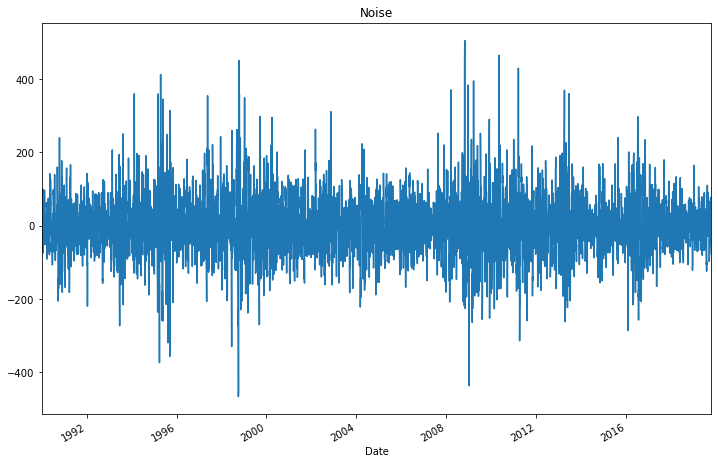

In [8]:
# Plot the Settle Noise
settle_noise.plot(title='Noise', figsize=(12, 8))
plt.margins(x=0)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
arma_model = ARMA(returns.Settle, order=(2,1))

# Fit the model and assign it to a variable called results
arma_results = arma_model.fit()

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [11]:
# Output model summary results:
arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 26 Apr 2021   AIC                          15798.142
Time:                        14:54:15   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3346           +0.0000j            3.3346            0.5000
AR.2         -157.1807           +0.0000j          157.1807            0.5000
MA.1           -3.3935           +0.0000j            3.3935            0.5000
-----------------------------------------------------------------------------
"""

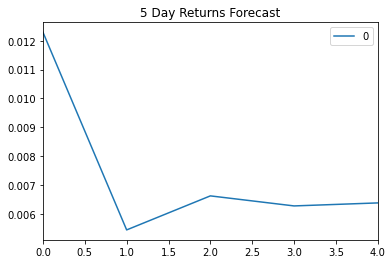

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(arma_results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")
plt.margins(x=0)

Answer:

We have created an ARMA model with the parameters, p=2 and q=1. From the above summary table, the model is ARMA(2,1) and the p-values of the lags are:

* ar. L1, here L1 represents the particular lag 1 that our model is using and the autoregressive term has p-value 0.811.
* ar. L2, here L2 represents the particular lag 2 that our model is using and the autoregressive term has p-value 0.921.
* ma. L1, here L1 represents the particular lag 2 that our model is using and the moving average term has p-value 0.818.

Based on the p-values, we observe that all the above p-values are greater than our given significance level (0.05). Thus, we conclude that the ARMA(2,1) model is not a good fit.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
raw_settle_price = yen_futures[["Settle"]]
raw_settle_price = raw_settle_price.replace(-np.inf, np.nan).dropna()
                               
arima_model = ARIMA(raw_settle_price.Settle, order=(5,1,1))

# Fit the model
arima_results = arima_model.fit()

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Mon, 26 Apr 2021   AIC                          83905.238
Time:                        14:54:16   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8918           -1.3786j            2.3408           -0.1002
AR.2            1.8918           +1.3786j            2.3408            0.1002
AR.3           -2.2700           -3.0206j            3.7785           -0.3526
AR.4           -2.2700           +3.0206j            3.7785            0.3526
AR.5          -11.0686           -0.0000j           11.0686           -0.5000
MA.1            3.3648           +0.0000j            3.3648            0.0000
-----------------------------------------------------------------------------
"""

Answer:

We have an ARIMA model and the parameters that we have set are p=5, d=1 and q=1. 

From the above summary table, the model is ARIMA(5,1,1) and the p-values of the lags are:

* constant has p-value 0.652.
* ar. L1, here L1 represents the particular lag 1 that our model is using and the autoregressive term has p-value 0.687.
* ar. L2, here L2 represents the particular lag 2 that our model is using and the autoregressive term has p-value 0.966.
* ar. L3, here L3 represents the particular lag 3 that our model is using and the autoregressive term has p-value 0.302.
* ar. L4, here L4 represents the particular lag 4 that our model is using and the autoregressive term has p-value 0.374.
* ar. L5, here L5 represents the particular lag 5 that our model is using and the autoregressive term has p-value 0.949.
* ma. L1, here L1 represents the particular lag 1 that our model is using and the moving average term has p-value 0.671.

Based on the p-values, we observe that all the above p-values are greater than our given significance level (0.05). From this, we conclude that the ARIMA(5,1,1) model is also not a good fit.

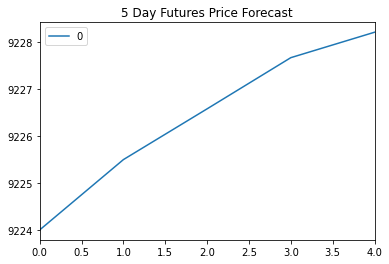

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")
plt.margins(x=0)

Answer:

From the above 5 day forecast model for the Settle Price, we can observe that in the near term the Japanese Yen will increase significantly.  

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch as arch
from arch import arch_model

In [17]:
# Estimate a GARCH model:
garch_model = arch_model(returns.Settle, mean="Zero", vol="Garch", p=2, q=1)

# Fit the model
garch_results = garch_model.fit(disp="off")

In [18]:
# Summarize the model results
garch_results

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Apr 26 2021   Df Residuals:                     7510
Time:                        14:54:17   Df Model:                            4
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02 

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


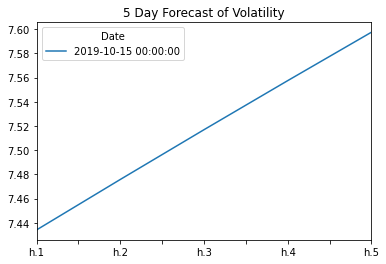

In [23]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")
plt.margins(x=0)

---

# Conclusions

**Based on your time series analysis, would you buy the yen now?**

Based on the above time series analysis, we wouldn't buy the Yen now. As both the ARMA and ARIMA models have the p-values greater than our significance level (0.05). Therefore, the autoregressive term is not statistically significant and those terms should not be kept in the models. 


**Is the risk of the yen expected to increase or decrease?**

From the above Garch model, we can abserve that the volatility rate is increasing rapidly. As risk is associated with the market volatility, we conclude that the risk of the yen is expected to increase. Investors may not be comfortable to take the risk at this level of volatility in the market.


**Based on the model evaluation, would you feel confident in using these models for trading?**

Based on the model evaluation, we would not feel confident in using these above models for trading. We know that the AIC and BIC values help us evaluate the strengths of the model and a lower value suggests that a model is better. But according to our ARMA and ARIMA models, the AIC and BIC values are very high and could not give us a lot of confidence for investing.